# Preprocessing Layers

In [1]:
import tensorflow as tf
import numpy as np
import os

2024-02-29 13:06:37.452954: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-29 13:06:37.486855: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-29 13:06:37.486906: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-29 13:06:37.487737: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-29 13:06:37.493832: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# Data field width in the csv:
n_inputs = 4 #+1 for the 'target' played by the last value

In [3]:
def parse_csv_line(line):
    # Default value for each column in the csv line
    # for feature columns, which can be missing
    # it defaults to zero float
    # The target however must be present so default value specification is absent
    # and only type is provided. Exception will raise
    # on missing target in the csv line [-1] position
    defs = [0.] * n_inputs + [tf.constant([], dtype=tf.float32)]
    fields = tf.io.decode_csv(line, record_defaults=defs)
    return tf.stack(fields[:-1]), tf.stack(fields[-1:])

In [4]:
def preprocess(line):
    x, y = parse_csv_line(line)
    return x, y

In [5]:
def csv_reader_dataset(filepaths, n_reads=5, n_read_threads=None,
                      n_parse_threads=5, shuffle_buffer_size=10,
                      seed=42, batch_size=32):
    dataset = tf.data.Dataset.list_files(filepaths, seed=seed)

    dataset = dataset.interleave(lambda filepath: tf.data.TextLineDataset(filepath).skip(1),
                                cycle_length=n_reads,
                                num_parallel_calls=n_read_threads)
    dataset = dataset.map(preprocess, num_parallel_calls=n_parse_threads)#.cache()
    dataset = dataset.shuffle(shuffle_buffer_size, seed=seed)
    return dataset.batch(batch_size).prefetch(1)


In [6]:
filepaths = './datasets/housing/'
train_filepaths = os.listdir(filepaths)
train_filepaths = [filepaths + train_filepaths[i] for i in range(len(train_filepaths))]

In [86]:
ds = csv_reader_dataset(train_filepaths, batch_size=2)

## Normalization Layer

## Building auxilliary features only dataset for normalization

In [96]:
norm_layer = tf.keras.layers.Normalization()

In [97]:
ds_norm = ds.map(lambda x, y: x)

In [ ]:
norm_layer.adapt(ds_norm)

In [100]:
for x, _ in ds.take(5):
    print(norm_layer(x))

tf.Tensor(
[[ 2.2052715   2.14725     2.0896633   2.030825  ]
 [-0.3257521  -0.37421784 -0.43264613 -0.4634407 ]], shape=(2, 4), dtype=float32)
tf.Tensor(
[[-0.13826889  0.14608504  0.3380595   0.49115473]
 [-0.56010616 -0.6463763  -0.6078065  -0.6174077 ]], shape=(2, 4), dtype=float32)
tf.Tensor(
[[-0.60228986 -0.6463763  -0.70239305 -0.7282639 ]
 [-0.57885444 -0.62636465 -0.68487704 -0.71286726]], shape=(2, 4), dtype=float32)


## Normalizing explicit tensor

In [109]:
norm_layer = tf.keras.layers.Normalization()

In [104]:
X = []
for x, _ in ds.take(5):
    X.append(x)

In [105]:
X

[<tf.Tensor: shape=(2, 4), dtype=float32, numpy=
 array([[600., 700., 800., 900.],
        [  1.,   2.,   3.,   4.]], dtype=float32)>,
 <tf.Tensor: shape=(2, 4), dtype=float32, numpy=
 array([[ 60.,  70.,  80.,  90.],
        [100., 200., 300., 400.]], dtype=float32)>,
 <tf.Tensor: shape=(2, 4), dtype=float32, numpy=
 array([[ 6.,  7.,  8.,  9.],
        [10.,  2., 30., 40.]], dtype=float32)>]

In [106]:
X = tf.concat(X, axis=0)

In [111]:
norm_layer.adapt(np.array(X))

In [112]:
for x, _ in ds.take(5):
    print(norm_layer(x))

tf.Tensor(
[[ 2.2052715   2.14725     2.0896633   2.030825  ]
 [-0.60228986 -0.6463763  -0.70239305 -0.7282639 ]], shape=(2, 4), dtype=float32)
tf.Tensor(
[[-0.57885444 -0.62636465 -0.68487704 -0.71286726]
 [-0.56010616 -0.6463763  -0.6078065  -0.6174077 ]], shape=(2, 4), dtype=float32)
tf.Tensor(
[[-0.13826889  0.14608504  0.3380595   0.49115473]
 [-0.3257521  -0.37421784 -0.43264613 -0.4634407 ]], shape=(2, 4), dtype=float32)


## Normalization layer seems to require large sample, for small dataset it shows discrepancy with an explicit manual normalization

In [113]:
for x, _ in ds.take(1):
    print(x)

tf.Tensor(
[[100. 200. 300. 400.]
 [ 10.   2.  30.  40.]], shape=(2, 4), dtype=float32)


In [114]:
for x, _ in ds.take(5):
    print(norm_layer(x))

tf.Tensor(
[[ 2.2052715   2.14725     2.0896633   2.030825  ]
 [-0.13826889  0.14608504  0.3380595   0.49115473]], shape=(2, 4), dtype=float32)
tf.Tensor(
[[-0.56010616 -0.6463763  -0.6078065  -0.6174077 ]
 [-0.57885444 -0.62636465 -0.68487704 -0.71286726]], shape=(2, 4), dtype=float32)
tf.Tensor(
[[-0.3257521  -0.37421784 -0.43264613 -0.4634407 ]
 [-0.60228986 -0.6463763  -0.70239305 -0.7282639 ]], shape=(2, 4), dtype=float32)


In [115]:
x

<tf.Tensor: shape=(2, 4), dtype=float32, numpy=
array([[60., 70., 80., 90.],
       [ 1.,  2.,  3.,  4.]], dtype=float32)>

In [116]:
tf.reduce_mean(X)

<tf.Tensor: shape=(), dtype=float32, numpy=184.25>

In [117]:
(X - tf.reduce_mean(X)) / np.std(X)

<tf.Tensor: shape=(6, 4), dtype=float32, numpy=
array([[ 1.5134407 ,  1.8774674 ,  2.241494  ,  2.6055207 ],
       [-0.6670788 , -0.66343856, -0.65979826, -0.65615803],
       [-0.4523031 , -0.41590044, -0.37949777, -0.3430951 ],
       [-0.30669245,  0.0573342 ,  0.42136085,  0.78538746],
       [-0.6488775 , -0.6452372 , -0.641597  , -0.6379567 ],
       [-0.63431644, -0.66343856, -0.5615111 , -0.52510846]],
      dtype=float32)>

In [118]:
norm_layer(X)

<tf.Tensor: shape=(6, 4), dtype=float32, numpy=
array([[ 2.2052715 ,  2.14725   ,  2.0896633 ,  2.030825  ],
       [-0.60228986, -0.6463763 , -0.70239305, -0.7282639 ],
       [-0.3257521 , -0.37421784, -0.43264613, -0.4634407 ],
       [-0.13826889,  0.14608504,  0.3380595 ,  0.49115473],
       [-0.57885444, -0.62636465, -0.68487704, -0.71286726],
       [-0.56010616, -0.6463763 , -0.6078065 , -0.6174077 ]],
      dtype=float32)>

## Training model with adapter layer

In [119]:
model = tf.keras.Sequential([
    norm_layer,
    tf.keras.layers.Dense(1)
])

model.compile(loss="mse",
              optimizer=tf.keras.optimizers.SGD(learning_rate=2e-3))

In [120]:
model.fit(ds, epochs=5)

Epoch 1/5
3/3 [==============================] - 0s 5ms/step - loss: 209246.5156
Epoch 2/5
3/3 [==============================] - 0s 2ms/step - loss: 195630.6875
Epoch 3/5
3/3 [==============================] - 0s 2ms/step - loss: 183145.2656
Epoch 4/5
3/3 [==============================] - 0s 2ms/step - loss: 171704.0469
Epoch 5/5
3/3 [==============================] - 0s 3ms/step - loss: 161102.1094


2024-02-29 21:57:22.384877: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11131248818375729379
2024-02-29 21:57:22.384899: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12354606247163210591
2024-02-29 21:57:22.384906: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10751389438721174909


## Normalizing train set in advance to speed up training

## X_train, X_valid prepared in advance

In [ ]:
norm_layer = tf.keras.layers.Normalization()
norm_layer.adapt(X_train)
X_train_scaled = norm_layer(X_train)
X_valid_scaled = norm_layer(X_valid)

In [ ]:
model = tf.keras.models.Sequential([tf.keras.layers.Dense(1)])
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=2e-3))
model.fit(X_train_scaled, y_train, epochs=5,
validation_data=(X_valid_scaled, y_valid))

## Adding an adapted layer to a new model wrapping an old model trained without a preprecossing layer

In [ ]:
final_model = tf.keras.Sequential([norm_layer, model])

## Using preprocessing layer in dataset map

In [121]:
ds_normed = ds.map(lambda X, y: (norm_layer(X), y))

In [122]:
for x, _ in ds_normed.take(5):
    print(x)

tf.Tensor(
[[ 2.2052717   2.14725     2.0896633   2.030825  ]
 [-0.32575214 -0.37421784 -0.43264613 -0.4634407 ]], shape=(2, 4), dtype=float32)
tf.Tensor(
[[-0.56010616 -0.6463763  -0.6078065  -0.6174077 ]
 [-0.13826889  0.14608504  0.3380595   0.49115473]], shape=(2, 4), dtype=float32)
tf.Tensor(
[[-0.6022899  -0.6463763  -0.70239305 -0.7282639 ]
 [-0.5788545  -0.62636465 -0.68487704 -0.71286726]], shape=(2, 4), dtype=float32)


## Writing custom Normalization layer

In [135]:
class MyNormalization(tf.keras.layers.Layer):
    def adapt(self, X):
        self.mean_ = tf.math.reduce_mean(X, axis=0, keepdims=True)
        self.std_ = tf.math.reduce_std(X, axis=0, keepdims=True)
        #self.mean_ = np.mean(X, axis=0, keepdims=True)
        #self.std_ = np.std(X, axis=0, keepdims=True)

    def call(self, inputs):
        eps = tf.keras.backend.epsilon()
        return (inputs - self.mean_) / (self.std_ + eps)

In [136]:
my_norm = MyNormalization()

In [137]:
my_norm.adapt(X)

In [138]:
ds_my_normed = ds.map(lambda X, y: (my_norm(X), y))

## Discretization Layer proceduces categorical variables, which should later be encoded using one-hot or more advanced embedding

### Explicit bin boundaries

In [139]:
age = tf.constant([[10.], [93.], [57.], [18.], [37.], [5.]])
discretize_layer = tf.keras.layers.Discretization(bin_boundaries=[10., 50.])

In [141]:
age_categories = discretize_layer(age)
age_categories

<tf.Tensor: shape=(6, 1), dtype=int64, numpy=
array([[1],
       [2],
       [2],
       [1],
       [1],
       [0]])>

### Bin boundaries determined from data based on percentiles

In [142]:
discretize_layer = tf.keras.layers.Discretization(num_bins=3)
discretize_layer.adapt(age)
age_categories = discretize_layer(age)
age_categories

<tf.Tensor: shape=(6, 1), dtype=int64, numpy=
array([[1],
       [2],
       [2],
       [1],
       [2],
       [0]])>

## The CategoryEncoding Layer

### OneHot with specified number of tokens (i.e. range of category label)

In [143]:
onehot_layer = tf.keras.layers.CategoryEncoding(num_tokens=3)
onehot_layer(age_categories)

<tf.Tensor: shape=(6, 3), dtype=float32, numpy=
array([[0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.]], dtype=float32)>

### MultiHot Encoding for sever categories features present

In [144]:
two_age_categories = np.array([[1, 0], [2, 2], [2, 0]])

In [145]:
onehot_layer(two_age_categories)

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[1., 1., 0.],
       [0., 0., 1.],
       [1., 0., 1.]], dtype=float32)>

### MultiHot with class occurence count

In [146]:
onehot_layer_cnt = tf.keras.layers.CategoryEncoding(num_tokens=3, output_mode='count')

In [147]:
onehot_layer_cnt(two_age_categories)

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[1., 1., 0.],
       [0., 0., 2.],
       [1., 0., 1.]], dtype=float32)>

### MultiHot and count encodings loose information about which feature provided the corresponding categorical label, e.g. [1, 0] and [0, 1] would be encoded as [1, 1, 0]

### Such degeneracy can be lifted by shifting the second feature in samples by a constant and enlarging the number of tokens to be used by the one-hot encoder

### The result is an enlarged multihot encoding

In [149]:
onehot_layer = tf.keras.layers.CategoryEncoding(num_tokens=3 + 3)
# Shifting second feature values
onehot_layer(two_age_categories + [0, 3])

<tf.Tensor: shape=(3, 6), dtype=float32, numpy=
array([[0., 1., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 1.],
       [0., 0., 1., 1., 0., 0.]], dtype=float32)>

## StringLookup Layer: For string (non-numerical) categories labels
### (There also is an IntegerLookup layer for encoding integers)

In [154]:
cities =  ["Auckland", "Paris", "Paris", "San Francisco"]
str_lookup_layer = tf.keras.layers.StringLookup()

In [155]:
str_lookup_layer.adapt(cities)

In [157]:
str_lookup_layer([["Paris"], ["Auckland"], ["Auckland"], ["Montreal"]])

<tf.Tensor: shape=(4, 1), dtype=int64, numpy=
array([[1],
       [3],
       [3],
       [0]])>

### StrinLookup layer can directly output one-hot encoded strings

In [158]:
str_lookup_layer = tf.keras.layers.StringLookup(output_mode='one_hot')
str_lookup_layer.adapt(cities)
str_lookup_layer([["Paris"], ["Auckland"], ["Auckland"], ["Montreal"]])

<tf.Tensor: shape=(4, 4), dtype=float32, numpy=
array([[0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.]], dtype=float32)>

## For rare categories one can use multiple OOV buckets
### These increase the OOV laber above the default 0 leading to more unknown categories labels assigned by hash

### Five OOV buckets, so the first known category ID is 5 (counting from 0)

In [159]:
str_lookup_layer = tf.keras.layers.StringLookup(num_oov_indices=5)
str_lookup_layer.adapt(cities)
str_lookup_layer([["Paris"], ["Auckland"], ["Foo"], ["Bar"], ["Baz"]])

<tf.Tensor: shape=(5, 1), dtype=int64, numpy=
array([[5],
       [7],
       [4],
       [3],
       [4]])>

## Hashing Layer - the hashing trick for OOV

### This layer is not adapted, which is usable in out-of-core cases of too big dataset for adaptation
### There are of course hashing collisions

In [160]:
hashing_layer = tf.keras.layers.Hashing(num_bins=10)
hashing_layer([["Paris"], ["Tokyo"], ["Auckland"], ["Montreal"]])

<tf.Tensor: shape=(4, 1), dtype=int64, numpy=
array([[0],
       [1],
       [9],
       [1]])>

## Learnable Categorical Embedings

In [162]:
embedding_layer = tf.keras.layers.Embedding(input_dim=5, output_dim=2)
embedding_layer(np.array([2, 4, 2]))

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[-0.0332781 ,  0.03733936],
       [ 0.02305576, -0.01755147],
       [-0.0332781 ,  0.03733936]], dtype=float32)>

### Combining Embedding with StringLookup

In [163]:
ocean_prox  = ["<1H OCEAN", "INLAND", "NEAR OCEAN", "NEAR BAY", "ISLAND"]

In [197]:
input_layer = tf.keras.layers.Input(shape=[], dtype=tf.string)

In [198]:
str_lookup_layer = tf.keras.layers.StringLookup()
str_lookup_layer.adapt(ocean_prox)

In [199]:
lookup_and_embed = tf.keras.Sequential([
    input_layer,
    str_lookup_layer,
    tf.keras.layers.Embedding(input_dim=str_lookup_layer.vocabulary_size(),
                              output_dim=2)
])

In [200]:
in_data = np.array([["<1H OCEAN"], ["ISLAND"], ["<1H OCEAN"]])

In [201]:
lookup_and_embed(in_data)

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[-0.04727558,  0.00654351],
       [ 0.02575275, -0.02159556],
       [-0.04727558,  0.00654351]], dtype=float32)>

## Heterogenic numerical-categorical model

In [ ]:
X_train_num, X_train_cat, y_train  = [...]
X_val_num, X_val_cat, y_val  = [...]

In [202]:
num_input = tf.keras.layers.Input(shape=[8], name='num')
cat_input = tf.keras.layers.Input(shape=[], name='cat')

In [203]:
cat_embeddings = lookup_and_embed(cat_input)
encoded_inputs = tf.keras.layers.concatenate([num_input, cat_embeddings])
outputs = tf.keras.layers.Dense(1)(encoded_inputs)
model = tf.keras.models.Model(inputs=[num_input, cat_input], outputs=[outputs])

In [204]:
model.compile(loss="mse", optimizer="sgd")

In [ ]:
model.fit((X_train_num, X_train_cat), y_train,
         validation_data=((X_valid_num, X_valid_cat), y_valid),
         epochs=5)

### Alternative way of passing argument to a model with named inputs:


#### By input dict

In [ ]:
model.fit({"num":X_train_num, "cat":X_train_val}, y_train,
         validation_data=({"num":X_valid_num, "cat":X_valid_val}, y_valid),
         epochs=5)

#### By dataset with dict batches

In [ ]:
# Returning tuples
((X_batch_num, X_batch_cat), y_batch)
# Or retuening tuple with a dict
({"num":X_batch_num, "cat":X_batch_val}, y_batch)

## Text Preprocessing - TextVectorization tokenizer layer

In [206]:
train_data =  ["To be", "!(to be)", "That's the question", "Be, be, be."]

In [207]:
text_vec_layer = tf.keras.layers.TextVectorization()
text_vec_layer.adapt(train_data)

### 0 - padding token, 1 - UNK token
### By defauly layer pads to the longest sentence

## Tokenized sentences

In [208]:
text_vec_layer(["Be good!", "Question: be or be?"])

<tf.Tensor: shape=(2, 4), dtype=int64, numpy=
array([[2, 1, 0, 0],
       [6, 2, 1, 2]])>

### TextVectorization has many options, notably to return padded or ragged sequences with ragged=True

## More advanced tokens: "tf_idf": term-frequency × inverse-document-frequency 

In [214]:
text_vec_layer = tf.keras.layers.TextVectorization(output_mode="tf_idf")

### With counting output_mode like 'count' or "tf_idf" order of the words is lost

In [215]:
text_vec_layer.adapt(train_data)

In [212]:
text_vec_layer(["Be good!", "Question: be or be?"])

<tf.Tensor: shape=(2, 6), dtype=float32, numpy=
array([[0.96725637, 0.6931472 , 0.        , 0.        , 0.        ,
        0.        ],
       [0.96725637, 1.3862944 , 0.        , 0.        , 0.        ,
        1.0986123 ]], dtype=float32)>

## Using pretrained model components from TF Hub
* https://www.kaggle.com/models?tfhub-redirect=true
* https://huggingface.co/docs/transformers/index

In [217]:
import tensorflow_hub as hub

### Sentence embedding module, computes a mean of all input token embeddings

In [218]:
hub_layer = hub.KerasLayer("https://tfhub.dev/google/nnlm-en-dim50/2")

In [219]:
sentence_encodings = hub_layer(tf.constant(["To be", "Not to be"]))

In [220]:
sentence_encodings

<tf.Tensor: shape=(2, 50), dtype=float32, numpy=
array([[-0.25380966,  0.2770232 ,  0.00897354,  0.10017891,  0.13895258,
         0.15983935,  0.2542148 ,  0.02308549,  0.06764374,  0.12753682,
        -0.18835452,  0.0637053 , -0.03649804, -0.06841687,  0.00050382,
        -0.07630469, -0.14049445, -0.15997408,  0.01923311, -0.23810819,
         0.16124715, -0.15835685, -0.03020302,  0.03365015, -0.1423789 ,
         0.03431253, -0.08789413, -0.04428098, -0.14300768, -0.18721291,
         0.07088692,  0.15187295,  0.17696716, -0.23075299, -0.06852929,
        -0.07982804,  0.01206938, -0.00781805,  0.09044959,  0.14481017,
        -0.03361241,  0.03230896,  0.08059499,  0.10121974, -0.01247383,
        -0.03108743, -0.07261945, -0.10150179,  0.04755301,  0.30925837],
       [-0.20271902,  0.19796026, -0.07793471,  0.01841375,  0.19302422,
         0.04632796,  0.21946976, -0.0899661 ,  0.01986205,  0.19102433,
        -0.02184895, -0.13629502, -0.20267053, -0.04437584,  0.00761068,
 

## Image Processing Layers
* tf.keras.layers.Resizing
* tf.keras.layers.Rescaling
* tf.keras.layers.CenterCrop

In [229]:
import matplotlib.pyplot as plt

In [221]:
from sklearn.datasets import load_sample_images

In [222]:
images = load_sample_images()["images"]

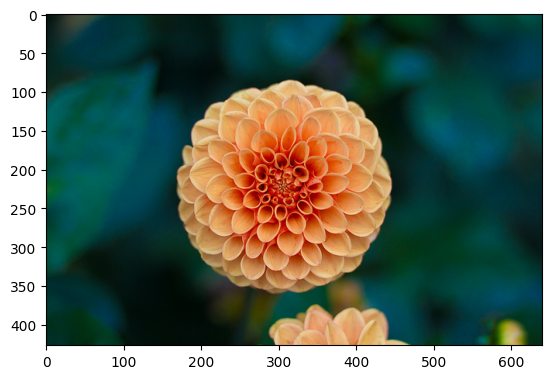

In [235]:
plt.imshow(images[1]/255)

In [223]:
crop_image_layer = tf.keras.layers.CenterCrop(height=100, width=100)

In [224]:
cropped_images = crop_image_layer(images)

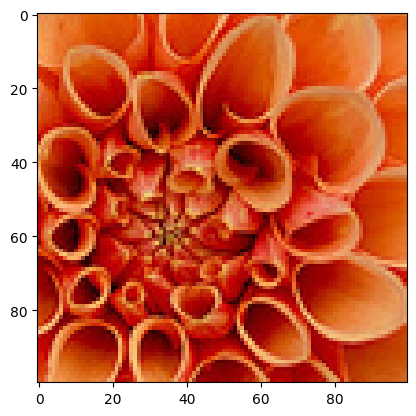

In [234]:
plt.imshow(cropped_images[1]/255)

## Keras image data augmentation layers:
* RandomCrop
* RandomFlip
* RandomTranslation
* RandomRotation
* RandomZoom
* RandomHeigh, RandomWidth
* RandomContrast

## TensorFlow Datasets
* https://www.tensorflow.org/datasets
* https://knowyourdata.withgoogle.com/

In [237]:
import tensorflow_datasets as tfds

### TFDS returns a dictionary of datasets

In [ ]:
datasets = tfds.load(name='mnist')

In [239]:
mnist_train, mnist_test = datasets['train'], datasets['test']

In [240]:
mnist_train

<_PrefetchDataset element_spec={'image': TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>

In [242]:
for batch in mnist_train.shuffle(10_000, seed=42).batch(32).prefetch(1):
    images = batch['image']
    labels = batch['label']
    # Used somehowe ...

## Preparing data in Keras expected form of (X, y) tuple
#### This can be also achieved by setting *as_supervised=True* in tfds.load()

In [243]:
mnist_train = mnist_train.shuffle(10_000, seed=42).batch(32)
mnist_train = mnist_train.map(lambda item: (item['image'], item['label']))
mnist_train = mnist_train.prefetch(1)

In [244]:
mnist_train

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

## Splitting fetched dataset into more parts

In [246]:
train_set, valid_set, test_set = tfds.load(
    name='mnist',
    split=['train[:90%]', 'train[90%:]', "test"],
    as_supervised=True
)

In [247]:
train_set = train_set.shuffle(buffer_size=10_000, seed=42).batch(32).prefetch(1)
valid_set = valid_set.batch(32).cache()
test_set = test_set.batch(32).cache()

tf.random.set_seed(42)

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [248]:
model.compile(loss='sparse_categorical_crossentropy',
             optimizer='nadam',
             metrics=['accuracy'])

In [249]:
history = model.fit(train_set, validation_data=valid_set, epochs=5)

Epoch 1/5
  47/1688 [..............................] - ETA: 1s - loss: 69.1656 - accuracy: 0.3717    

2024-03-01 18:35:13.752574: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


1688/1688 [==============================] - 2s 1ms/step - loss: 9.7980 - accuracy: 0.8359 - val_loss: 5.9844 - val_accuracy: 0.8833
Epoch 2/5
1688/1688 [==============================] - 2s 960us/step - loss: 5.7286 - accuracy: 0.8798 - val_loss: 5.7311 - val_accuracy: 0.8715
Epoch 3/5
1688/1688 [==============================] - 2s 1ms/step - loss: 5.2781 - accuracy: 0.8832 - val_loss: 6.0442 - val_accuracy: 0.8708
Epoch 4/5
1688/1688 [==============================] - 2s 1ms/step - loss: 5.0332 - accuracy: 0.8853 - val_loss: 6.3143 - val_accuracy: 0.8683
Epoch 5/5
1688/1688 [==============================] - 2s 977us/step - loss: 4.9101 - accuracy: 0.8868 - val_loss: 5.7304 - val_accuracy: 0.8703


In [250]:
test_loss, test_accuracy = model.evaluate(test_set)

313/313 [==============================] - 0s 803us/step - loss: 5.4031 - accuracy: 0.8782


In [251]:
test_accuracy

0.8781999945640564